# COVID-19 Data Analyses using Johns Hopkins Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is the Johns Hopkins University's Center for Systems Science and Engineering (CSSE) 
[COVID-19 data repository](https://github.com/CSSEGISandData/COVID-19).

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the Johns Hopkins COVID-19 CSV files into a [Pandas](https://pandas.pydata.org/) DataFrame. It
then manipulates, queries, and plots the DataFrame.

[**I don't want to look at code. Take me to the first graph!**](#United-States)

[bmc/covid19]: https://github.com/bmc/covid19/

## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import csv
import os
import sys
import re
import math
from pprint import pprint
from enum import Enum
from itertools import chain
from lib.common import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")

Using Python 3.8.4
Using matplotlib 3.2.2
Using Pandas 1.0.5


In [2]:
JOHNS_HOPKINS_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us'

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## Helpers

In [4]:
def make_month_day_column(df):
    df[COL_MONTH_DAY] = df[COL_DATE].dt.strftime('%m/%d')

# Read the data into a single Pandas DataFrame
def read_all_into_pandas():
    """
    Read all CSV files into a single Pandas DataFrame, normalizing
    the column names and discarding the ones we don't want.
    
    The DataFrame will be sorted by date.
    """
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    data_frames = []
    for f in os.listdir(JOHNS_HOPKINS_DIR_PATH):
        # Skip any file that doesn't match the regex. It'd
        # probably be sufficient to check the extension, but
        # this approach is more robust.
        m = f_pat.match(f)
        if m is None:
            continue
        df = pd.read_csv(os.path.join(JOHNS_HOPKINS_DIR_PATH, f))
        df['Date'] = m.group(1)
        # Now, convert to Pandas datetime. You can't store a regular
        # Python date or datetime in Pandas and then operate on it
        # using Pandas datetime functions. It has to be a Pandas
        # datetime.
        df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%Y')
        data_frames.append(df[[
            'Date', 'Province_State', 'Confirmed', 'Deaths', 'Recovered',
            'People_Tested', 'People_Hospitalized'
        ]])

    df2 = pd.concat(data_frames, ignore_index=True)
    
    final_df = df2.rename(columns={
        'Province_State':      COL_REGION,
        'Date':                COL_DATE,
        'Deaths':              COL_DEATHS,
        'People_Tested':       COL_TESTS,
        'Confirmed':           COL_CASES,
        'Recovered':           COL_RECOVERIES,
        'People_Hospitalized': COL_HOSPITALIZATIONS
    })

    for col in (COL_DEATHS, COL_CASES, COL_TESTS, COL_RECOVERIES, COL_HOSPITALIZATIONS):
        final_df[col] = final_df[col].fillna(0)

    final_df = final_df.astype({
        COL_DEATHS: int,
        COL_CASES: int,
        COL_HOSPITALIZATIONS: int,
        COL_RECOVERIES: int,
        COL_TESTS: int
    })

    make_month_day_column(final_df)

    final_df.sort_values(by=[COL_DATE], inplace=True)
    return final_df

## Read the data

### Load the state population data

In [5]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,157


### Load the Johns Hopkins data

In [6]:
df = read_all_into_pandas()

In [7]:
df

,date,region,cases,deaths,recoveries,tests,hospitalizations,month_day
2039,2020-04-12,Alaska,272,8,66,8038,31,04/12
2066,2020-04-12,Missouri,4269,118,0,45200,988,04/12
2065,2020-04-12,Mississippi,2781,96,0,21413,548,04/12
2064,2020-04-12,Minnesota,1621,70,842,37421,361,04/12
2063,2020-04-12,Michigan,24244,1479,433,79437,3636,04/12
...,...,...,...,...,...,...,...,...
5143,2020-07-23,Maine,3737,118,3239,147675,378,07/23
5144,2020-07-23,Maryland,80836,3409,5434,789041,12037,07/23
5145,2020-07-23,Massachusetts,114647,8484,96452,1070062,11761,07/23
5147,2020-07-23,Minnesota,48721,1601,42524,905315,4818,07/23


In [8]:
jhu_starting_date = df.date.min().date()
jhu_ending_date = df.date.max().date()
# See https://stackoverflow.com/a/15411596
total_unique_dates = len(df.groupby('date').date.nunique())
print(f"Loaded data for {total_unique_dates} weeks.")
# len(dataframe.index) is the idiom for getting the number of rows.
print(f"Total rows: {len(df.index):,}")
print(f"Starting date: {datestr(jhu_starting_date, include_year=True)}")
print(f"Ending date: {datestr(jhu_ending_date, include_year=True)}")

Loaded data for 103 weeks.
Total rows: 5,992
Starting date: 04/12/2020
Ending date: 07/23/2020


## Deaths and cases in a single region

### United States

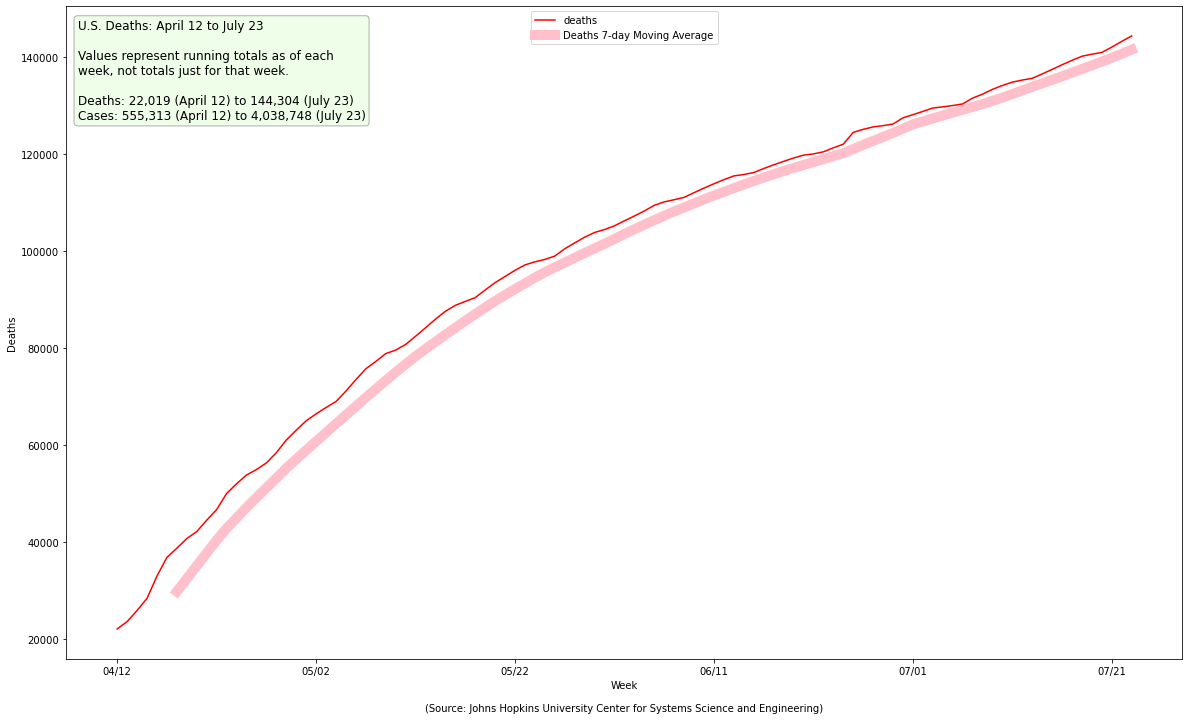

In [9]:
plot_stats_by_date(df, metrics={MetricType.DEATHS}, moving_average=True,
                   image_file='jhu-us-deaths.png', textbox_heading="U.S. Deaths")

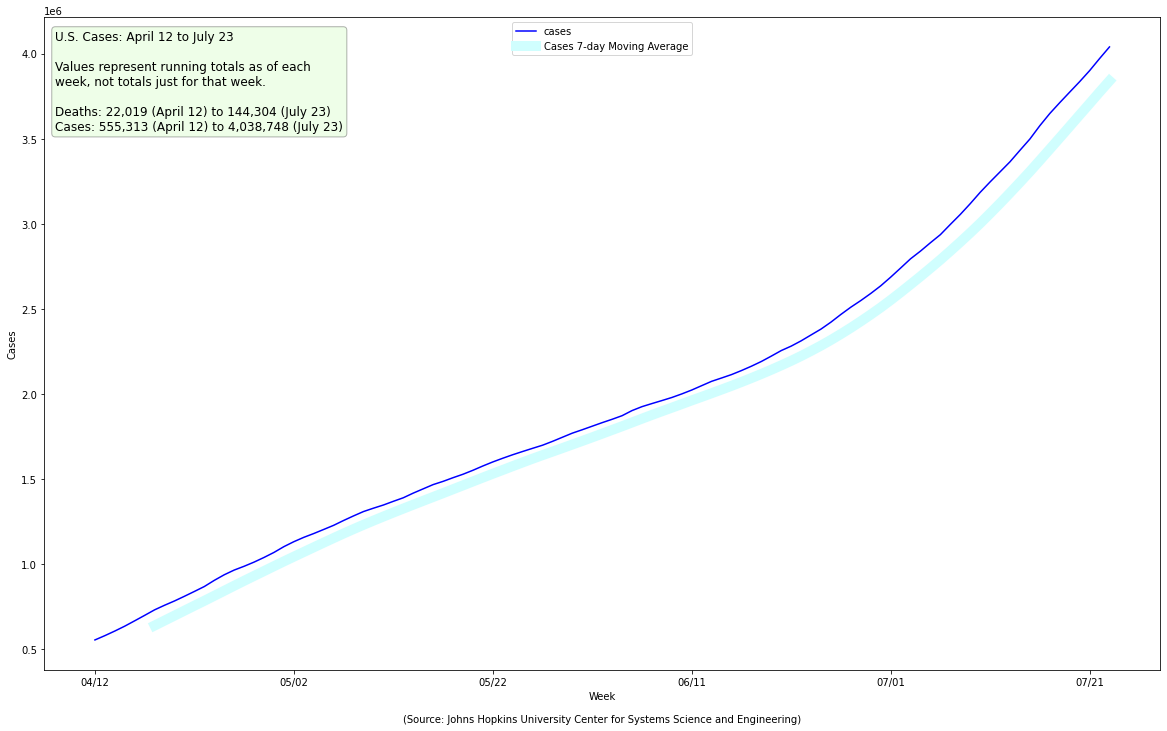

In [10]:
plot_stats_by_date(df, metrics={MetricType.CASES}, moving_average=True,
                   image_file='jhu-us-cases.png', textbox_heading="U.S. Cases")

#### Just the past week

In [11]:
week_delta = timedelta(days=6)
six_days_prior = jhu_ending_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(jhu_ending_date, hour=23, minute=59, second=59)

df_past_week = df.loc[(df[COL_DATE] >= last_week_start) & (df[COL_DATE] <= last_week_end)]

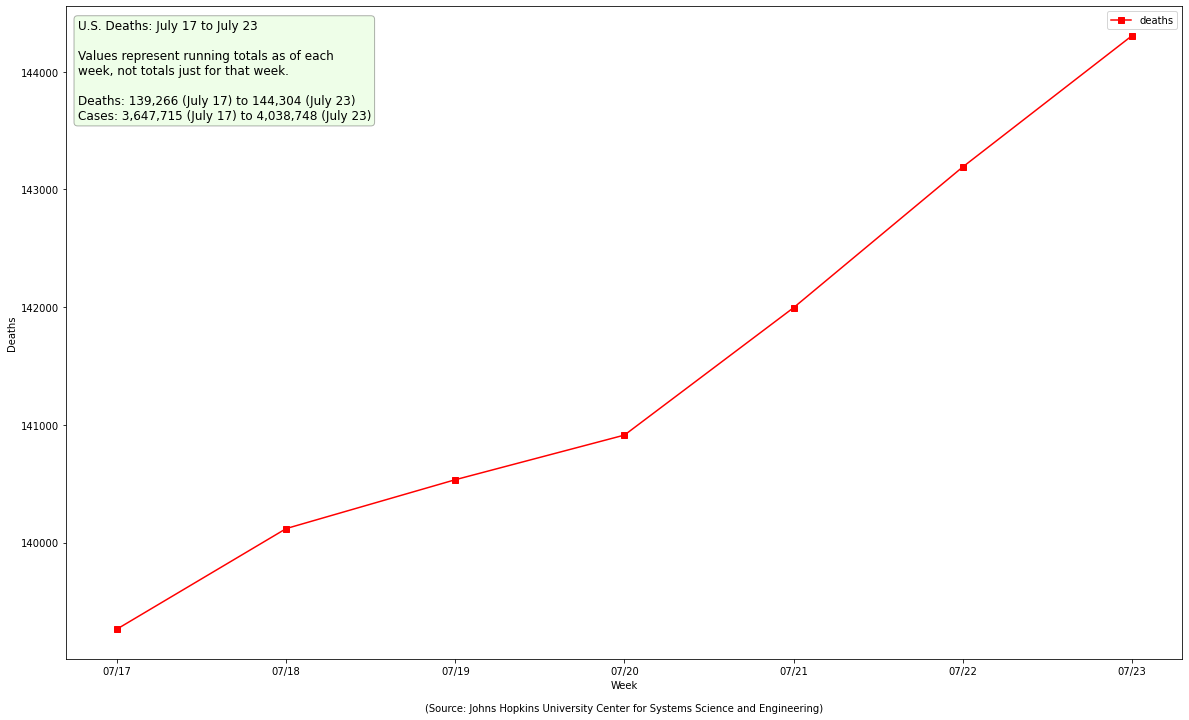

In [12]:
plot_stats_by_date(df_past_week, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='jhu-us-deaths-past-week.png')

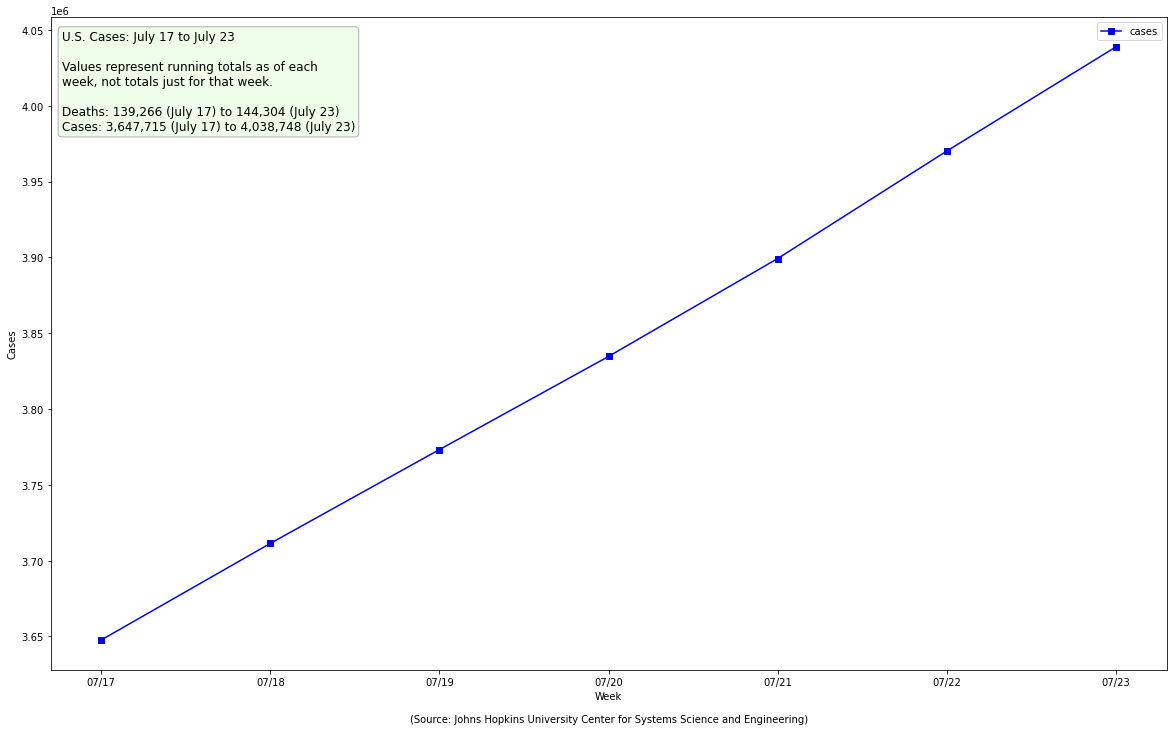

In [13]:
plot_stats_by_date(df_past_week, metrics={MetricType.CASES}, marker='s', 
                   textbox_heading="U.S. Cases", image_file='jhu-us-cases-past-week.png')

#### Deaths vs. Cases

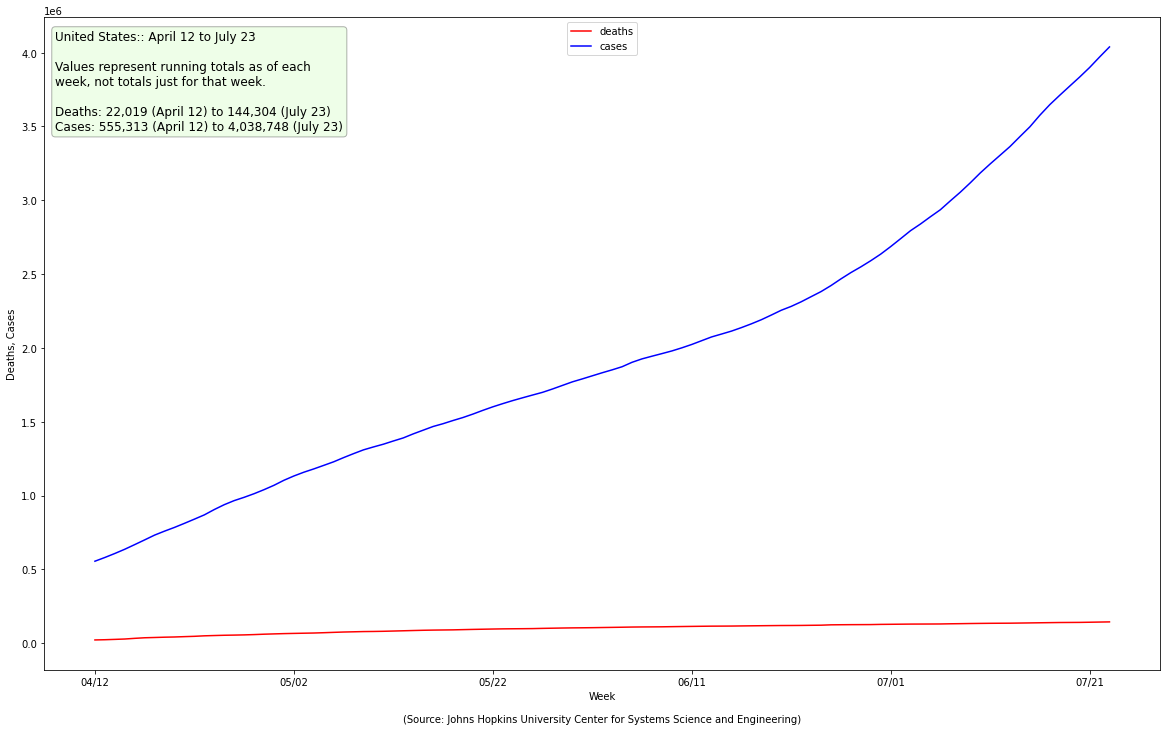

In [14]:
plot_stats_by_date(df, metrics={MetricType.DEATHS, MetricType.CASES}, textbox_heading="United States:",
                   image_file="jhu-us-deaths-and-cases.png")

### Individual States

#### Pennsylvania

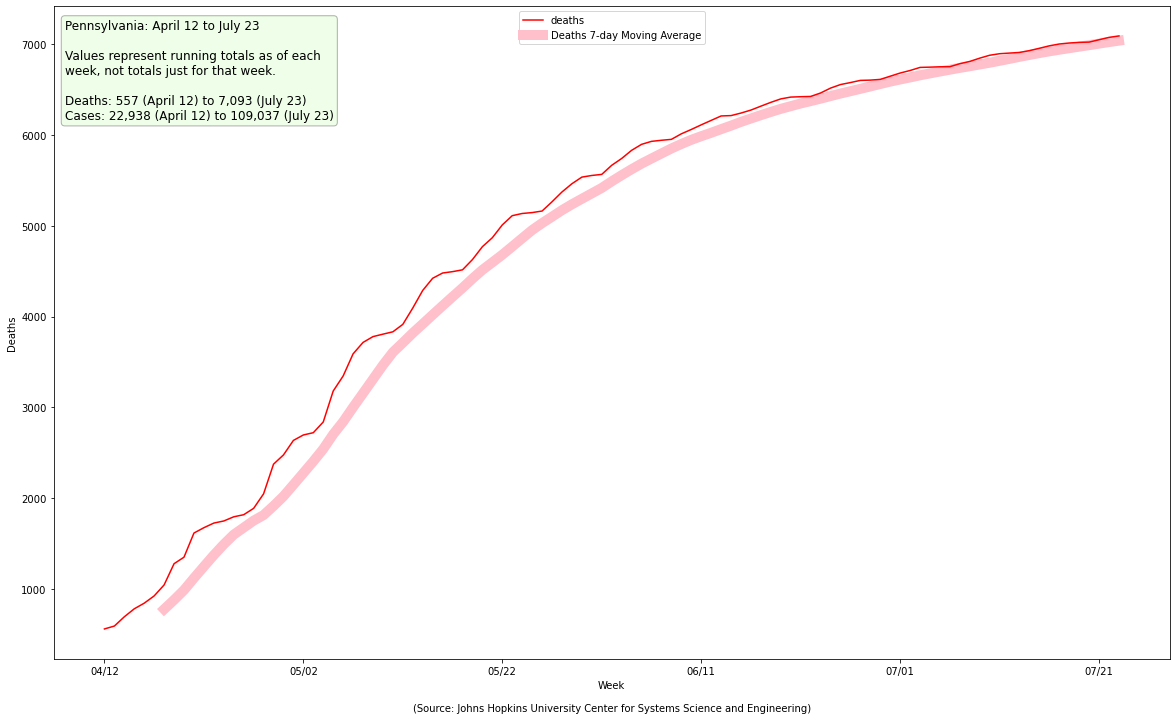

In [15]:
plot_state(df, 'Pennsylvania', image_file='jhu-pa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

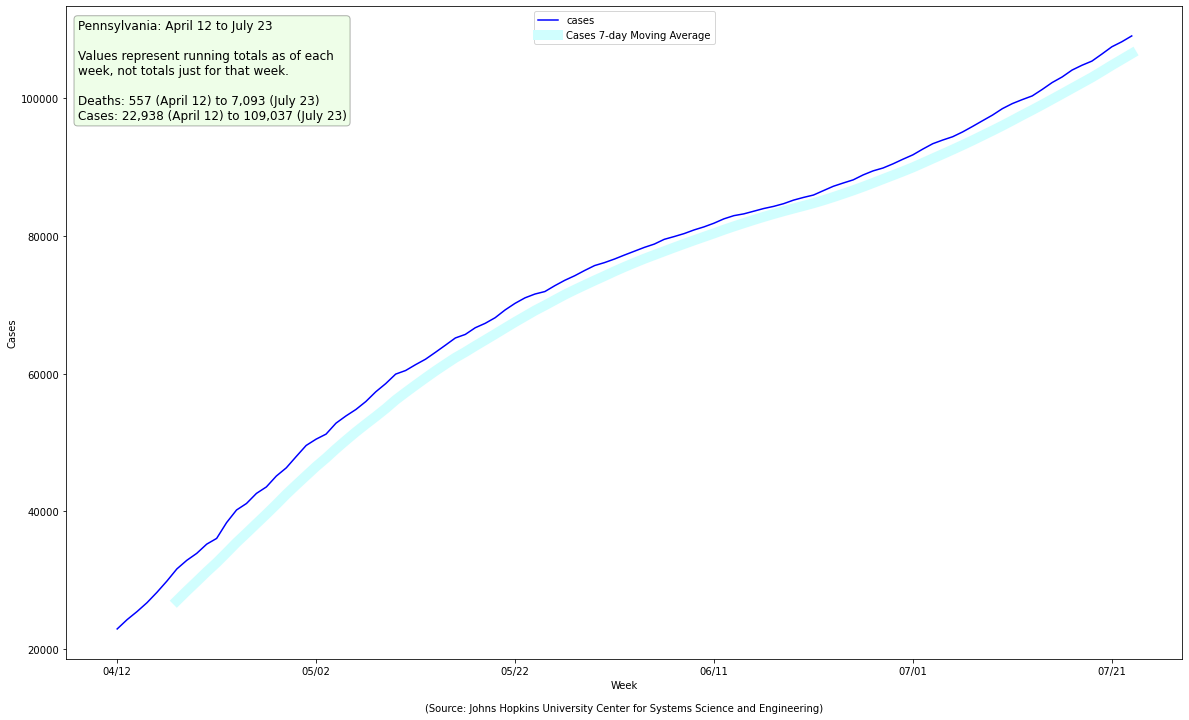

In [16]:
plot_state(df, 'Pennsylvania', image_file='jhu-pa-cases.png', metrics={MetricType.CASES}, moving_average=True)

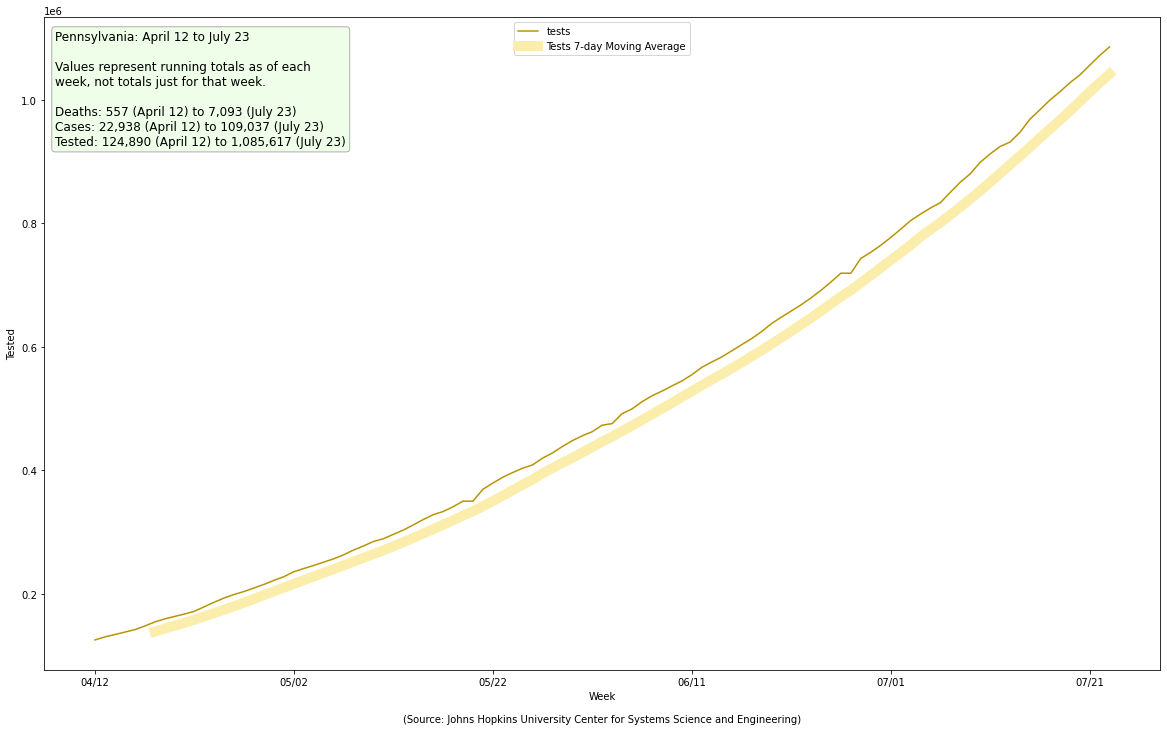

In [17]:
plot_state(df, 'Pennsylvania', image_file='jhu-pa-tests.png', metrics={MetricType.TESTED}, moving_average=True)

#### New York

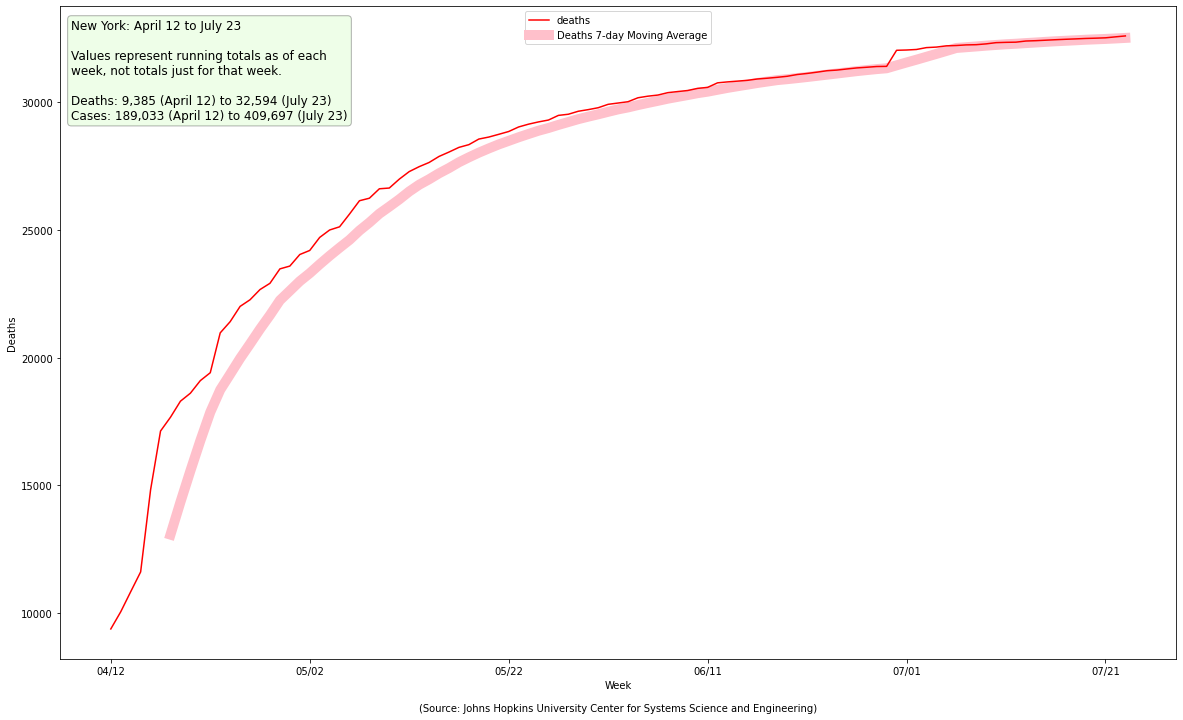

In [18]:
plot_state(df, 'New York', image_file='jhu-ny-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

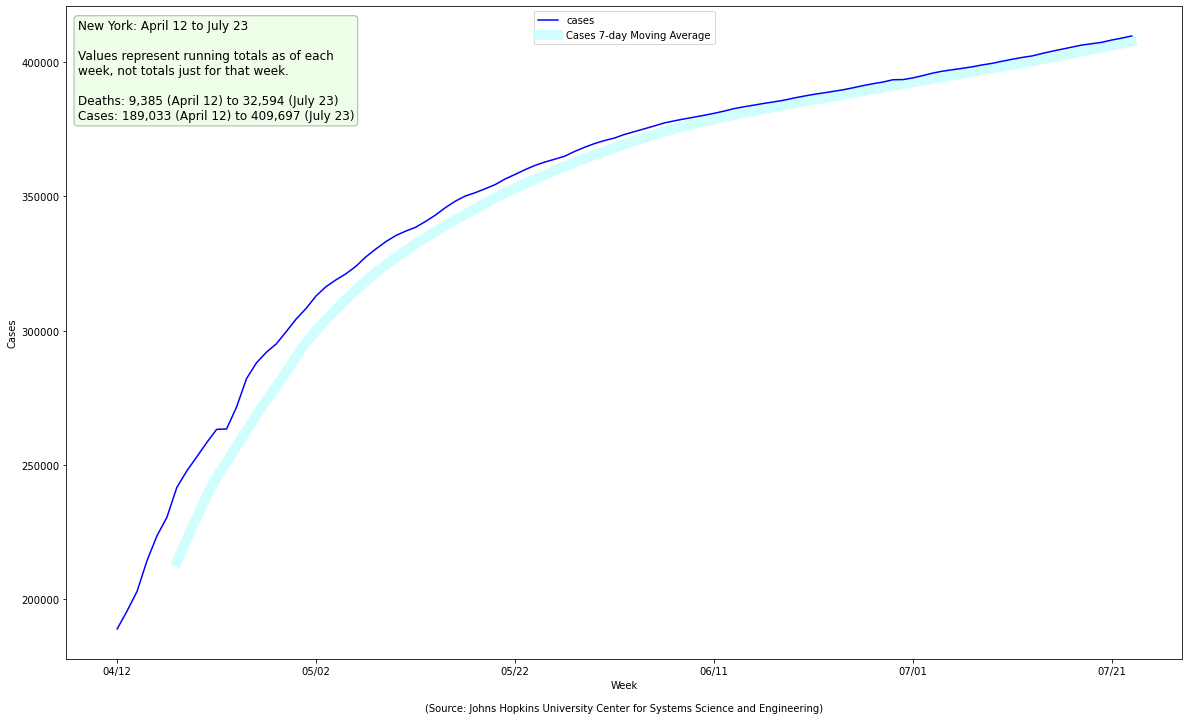

In [19]:
plot_state(df, 'New York', image_file='jhu-ny-cases.png', metrics={MetricType.CASES}, moving_average=True)

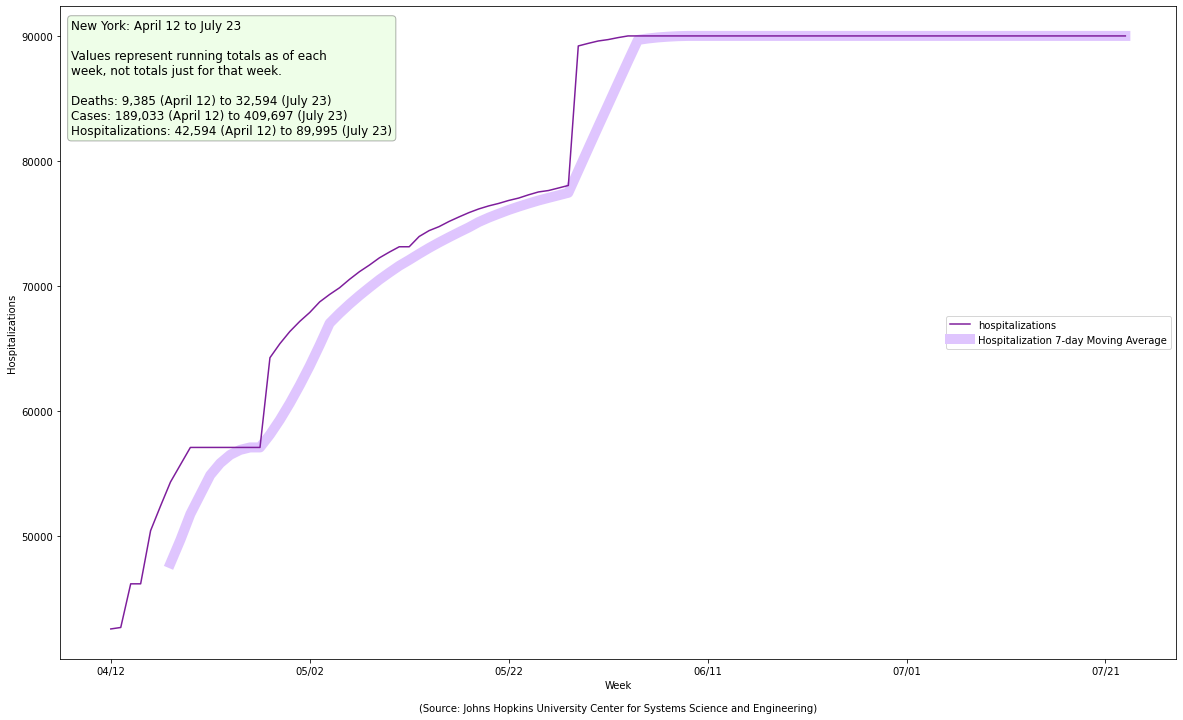

In [20]:
plot_state(df, 'New York', image_file='jhu-ny-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, 
           moving_average=True, legend_loc='center right')

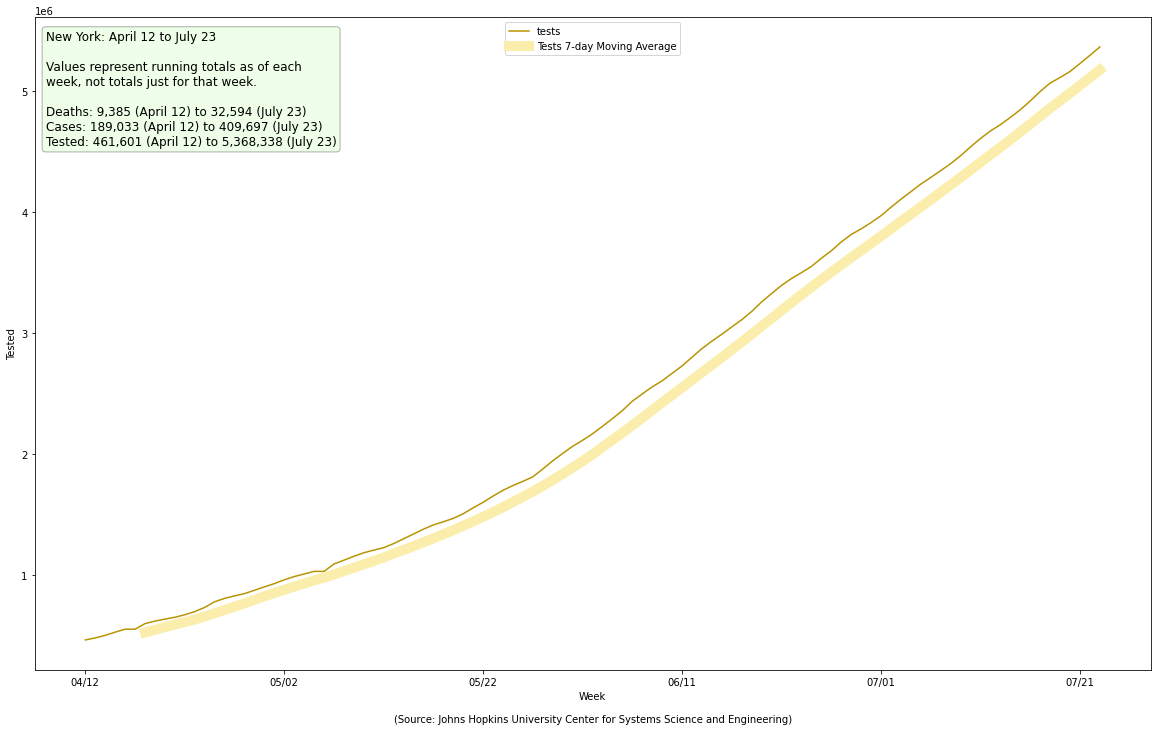

In [21]:
plot_state(df, 'New York', image_file='jhu-ny-tests.png', metrics={MetricType.TESTED}, moving_average=True)

#### Washington

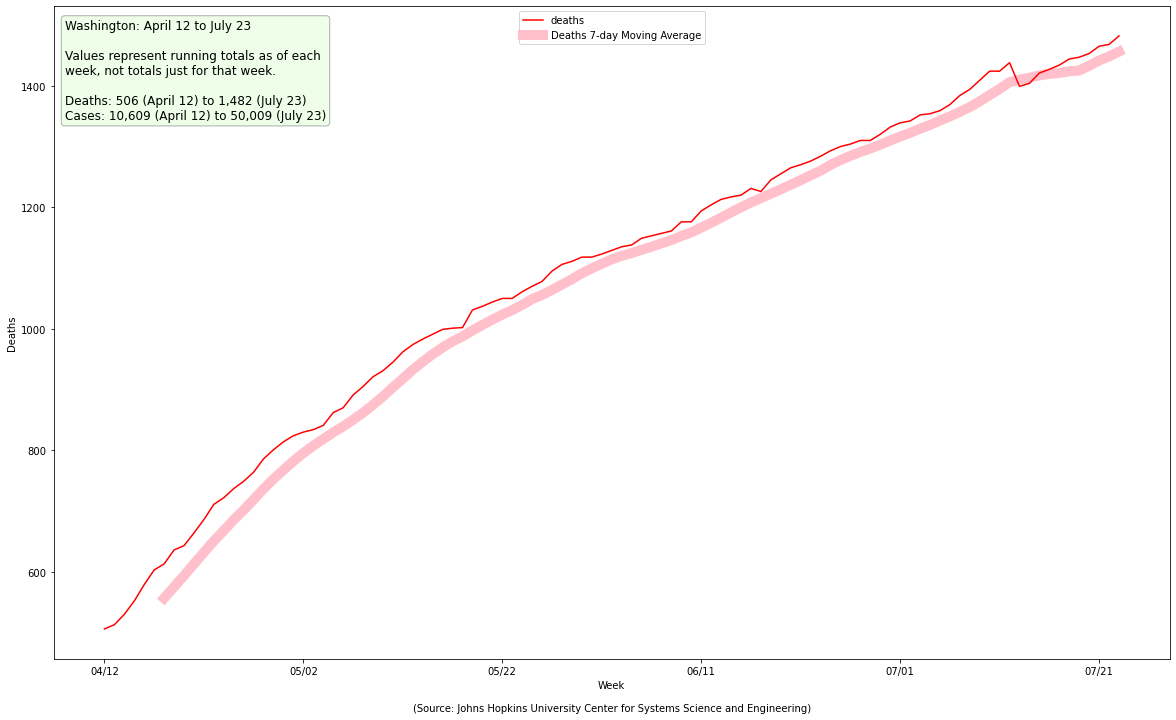

In [22]:
plot_state(df, 'Washington', image_file='jhu-wa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

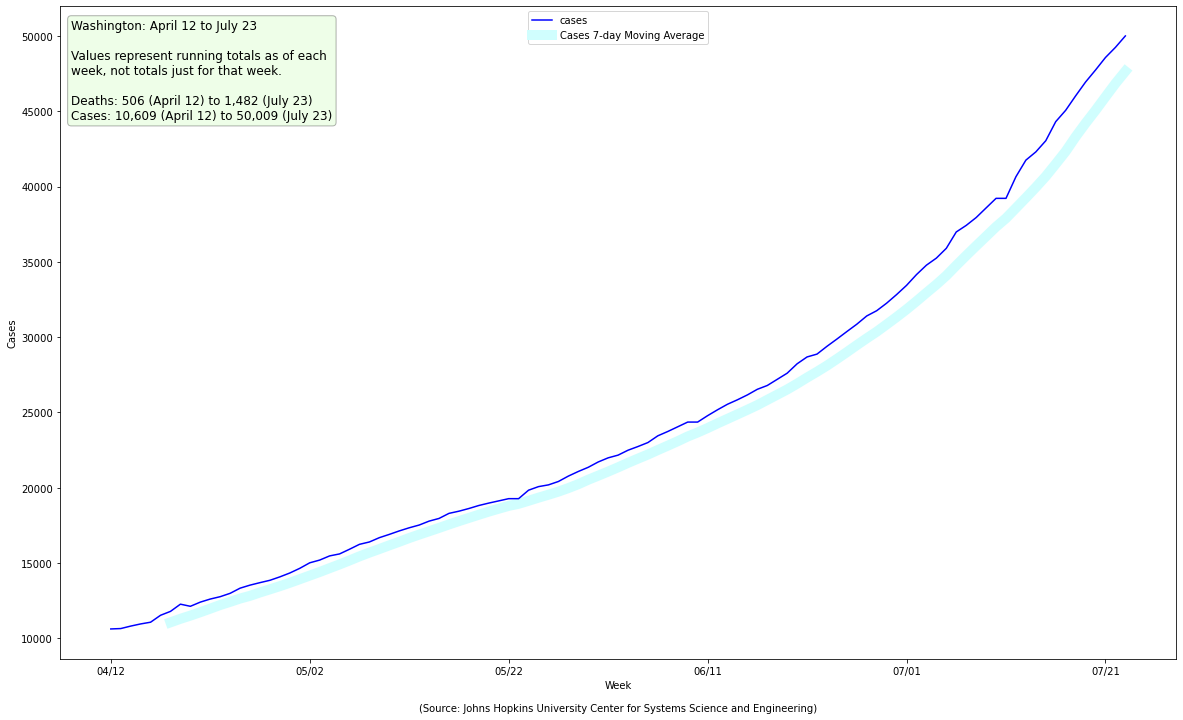

In [23]:
plot_state(df, 'Washington', image_file='jhu-wa-cases.png', metrics={MetricType.CASES}, moving_average=True)

#### Delaware

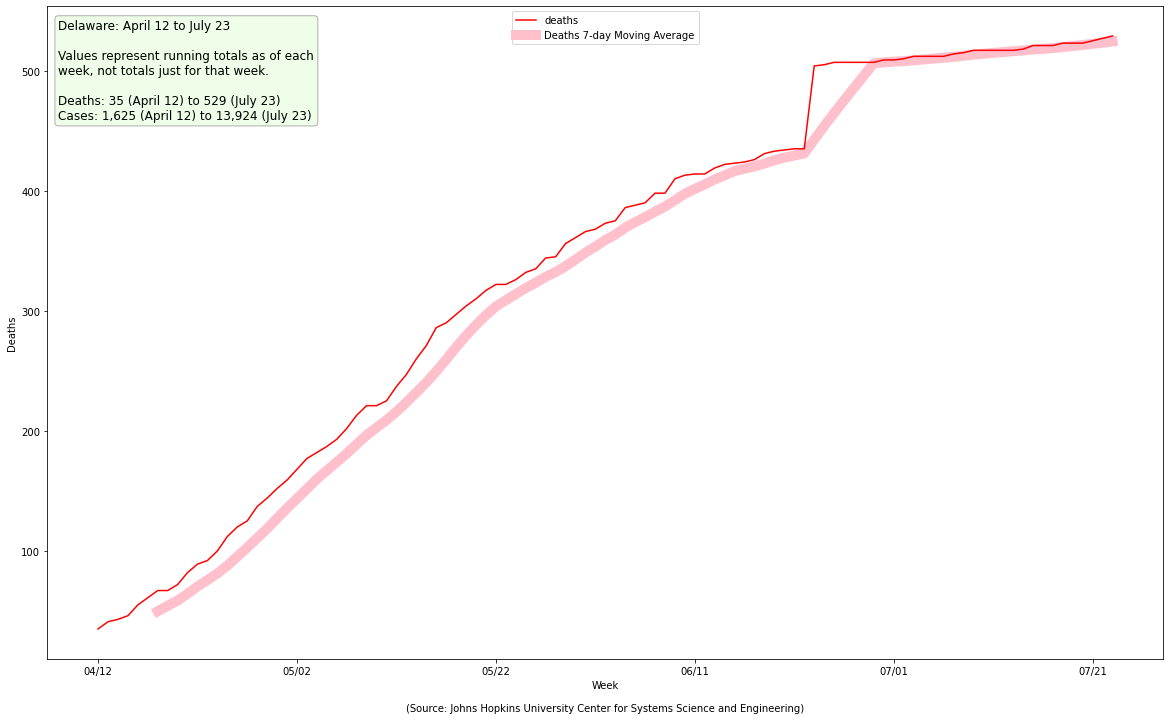

In [24]:
plot_state(df, 'Delaware', image_file='jhu-de-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

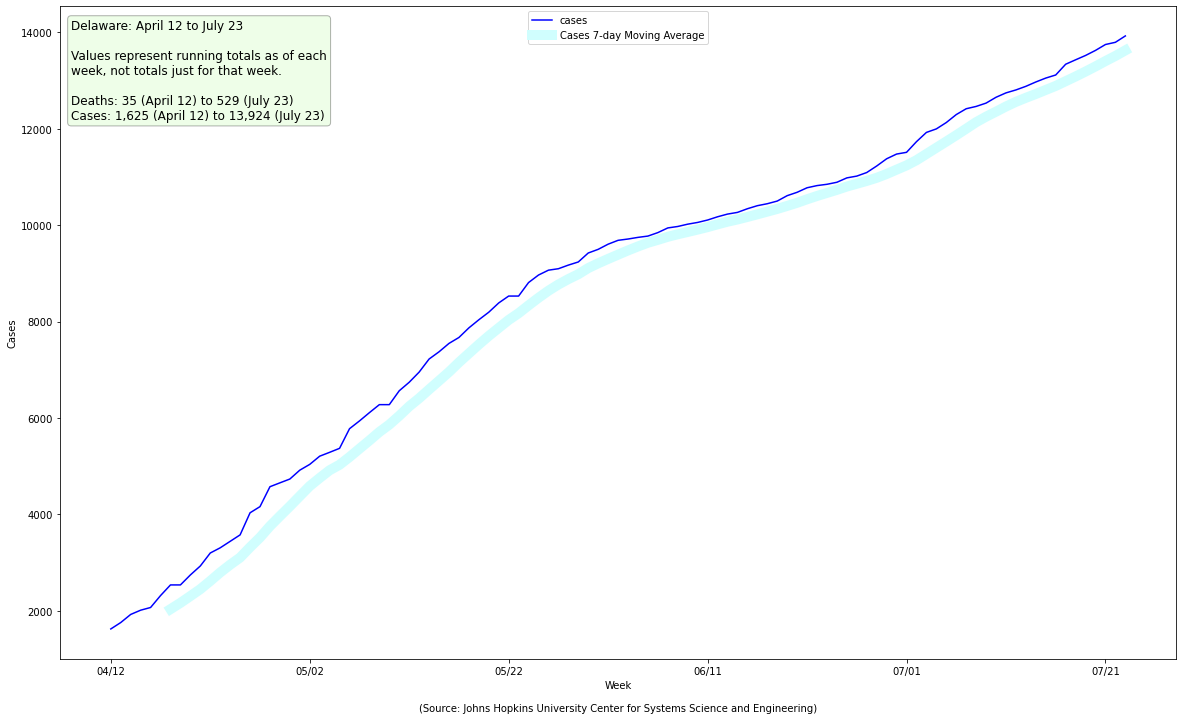

In [25]:
plot_state(df, 'Delaware', image_file='jhu-de-cases.png', metrics={MetricType.CASES}, moving_average=True)

#### Texas

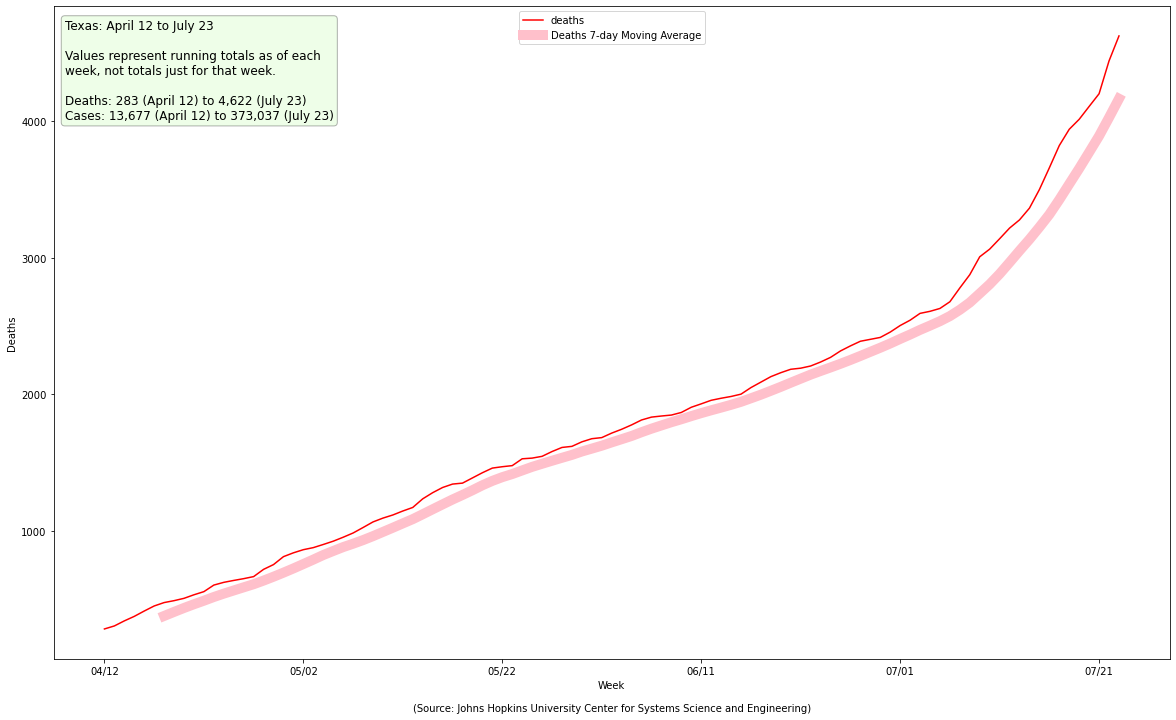

In [26]:
plot_state(df, 'Texas', image_file='jhu-tx-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

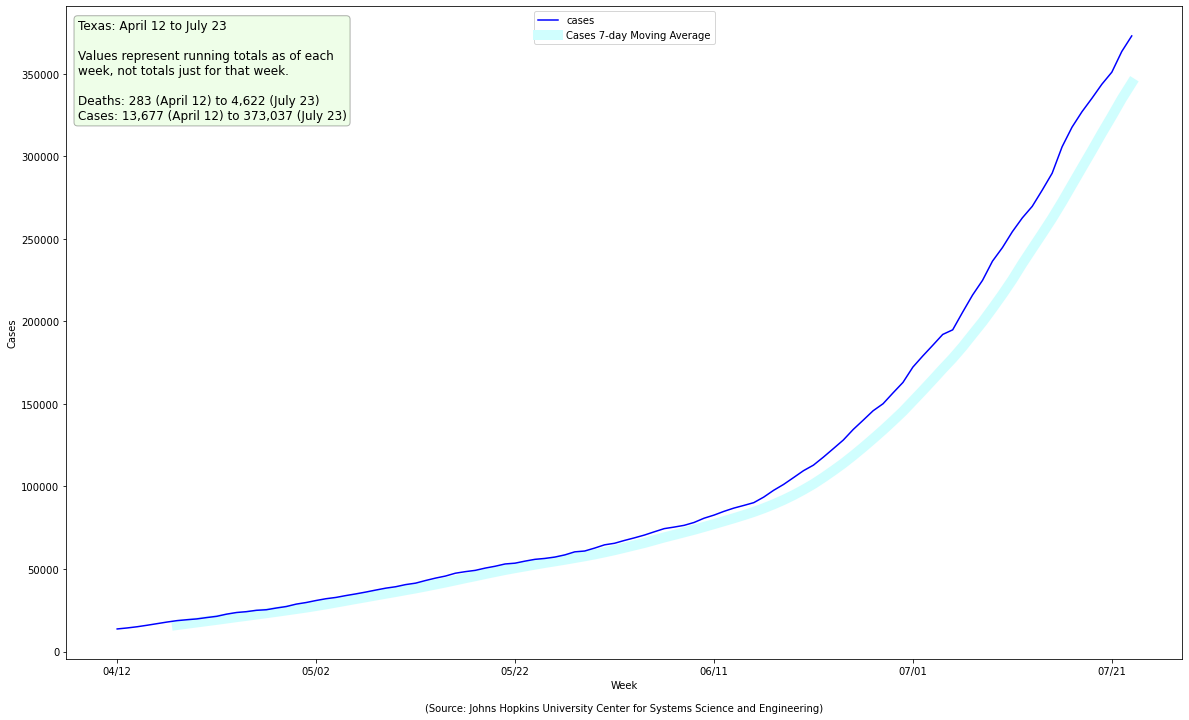

In [27]:
plot_state(df, 'Texas', image_file='jhu-tx-cases.png', metrics={MetricType.CASES}, moving_average=True)

#### Georgia

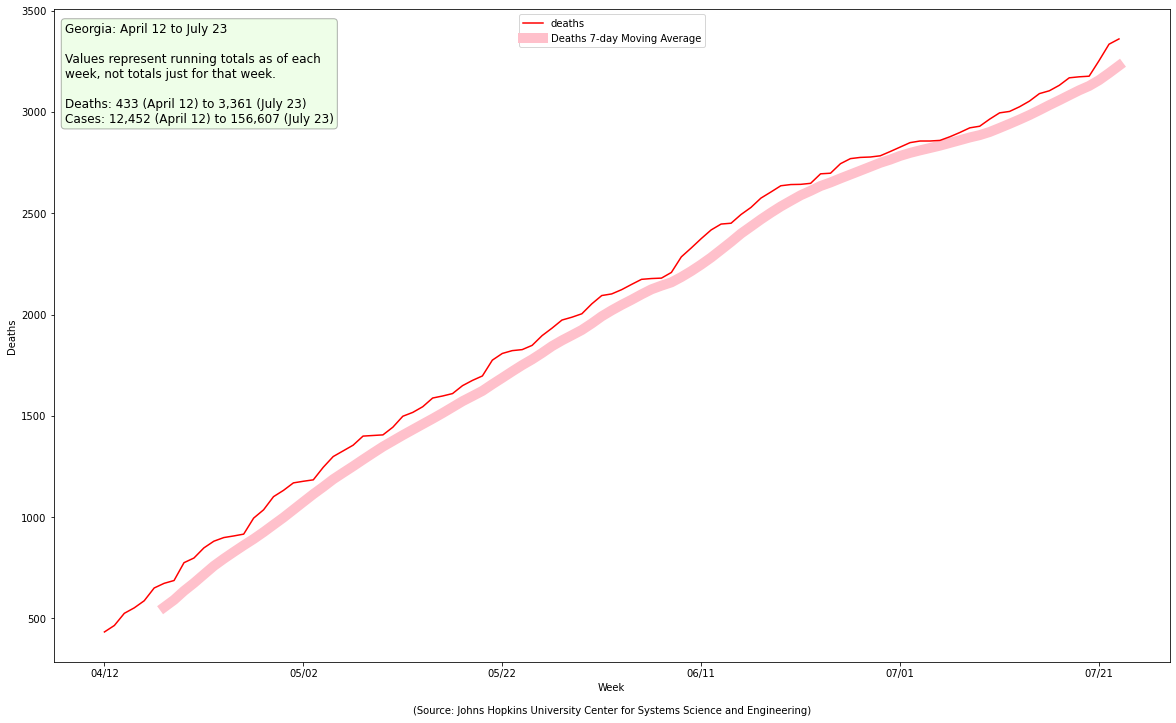

In [28]:
plot_state(df, 'Georgia', image_file='jhu-ga-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

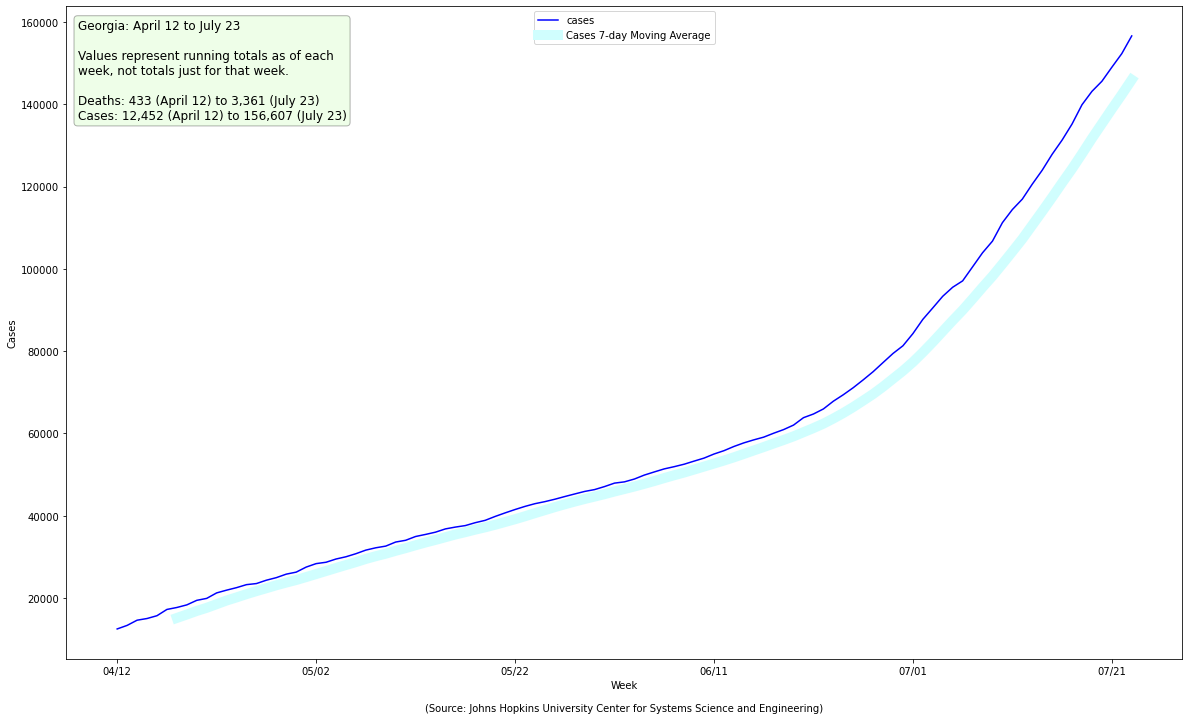

In [29]:
plot_state(df, 'Georgia', image_file='jhu-ga-cases.png', metrics={MetricType.CASES}, moving_average=True)

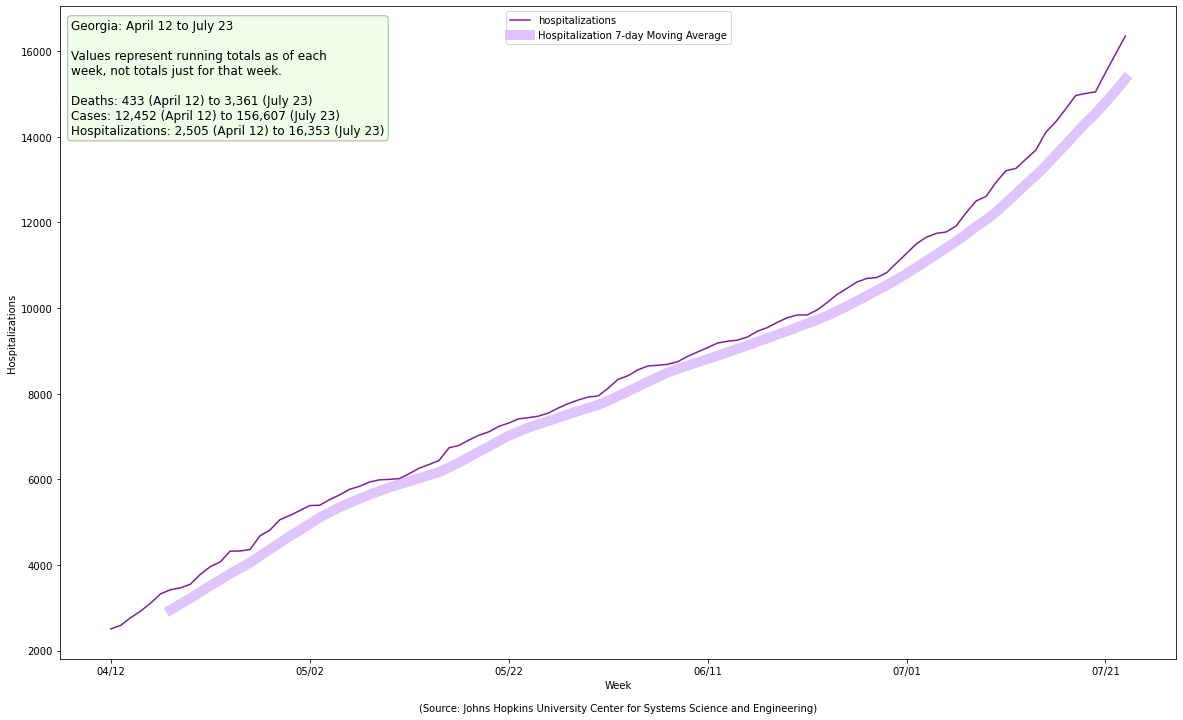

In [30]:
plot_state(df, 'Georgia', image_file='jhu-ga-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Mississippi

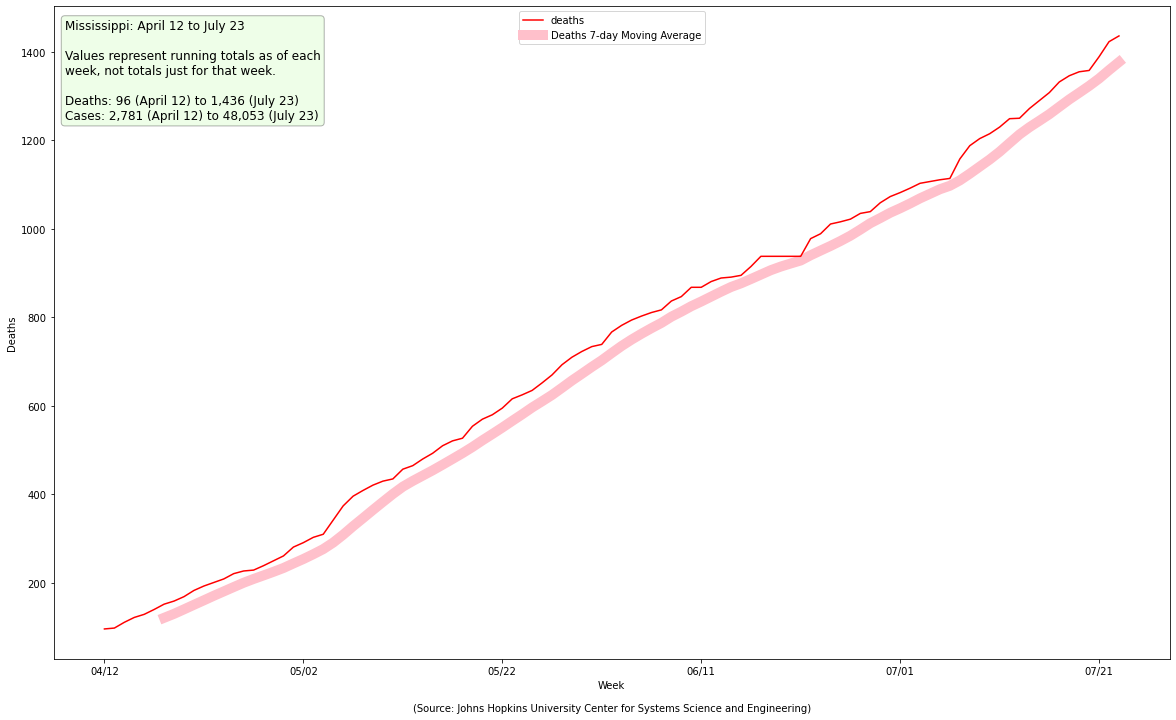

In [31]:
plot_state(df, 'Mississippi', image_file='jhu-ms-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

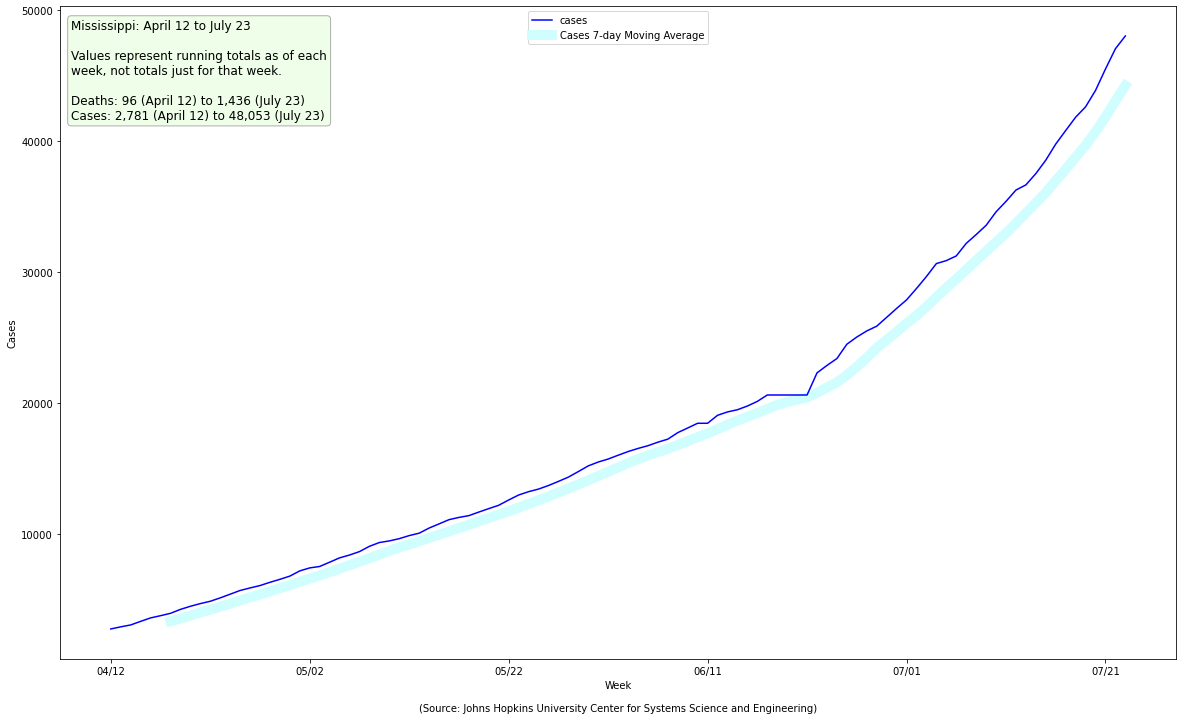

In [32]:
plot_state(df, 'Mississippi', image_file='jhu-ms-cases.png', metrics={MetricType.CASES}, moving_average=True)

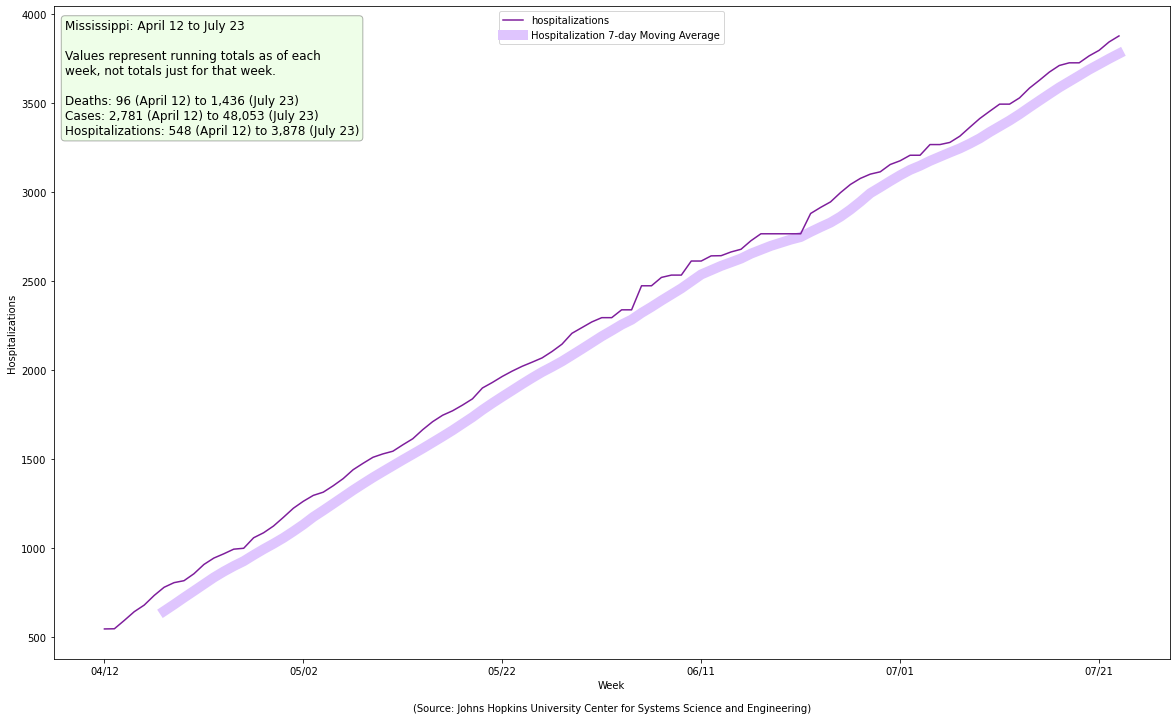

In [33]:
plot_state(df, 'Mississippi', image_file='jhu-ms-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Arizona

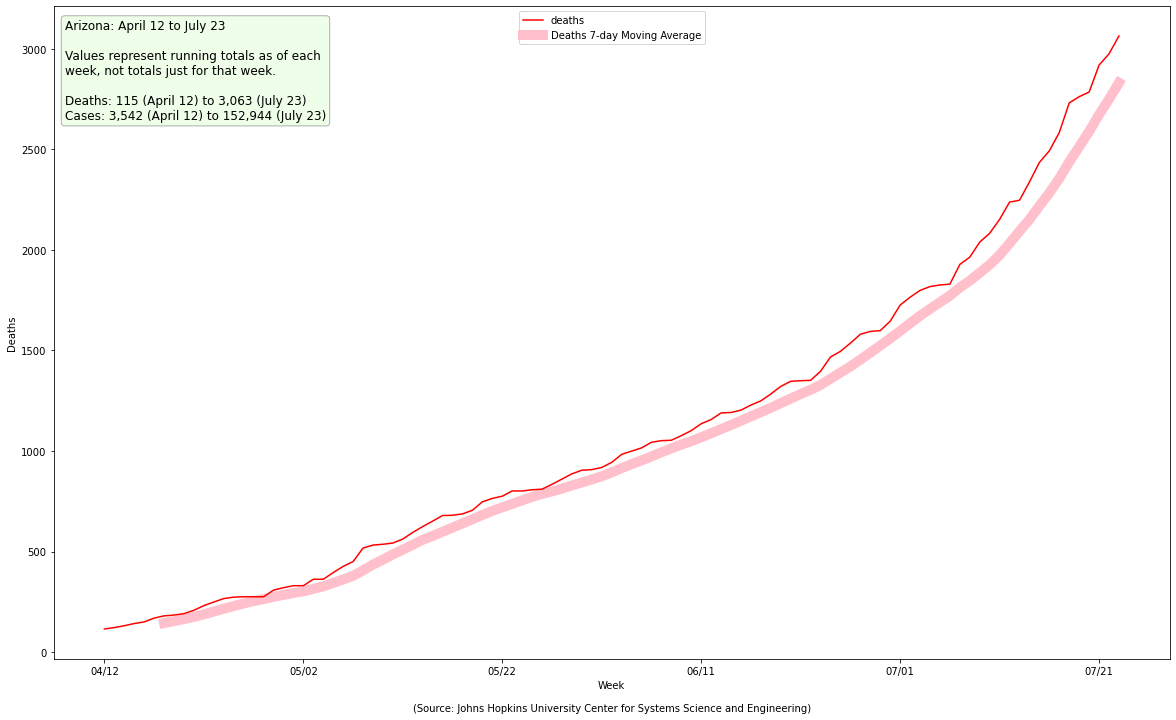

In [34]:
plot_state(df, 'Arizona', image_file='jhu-az-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

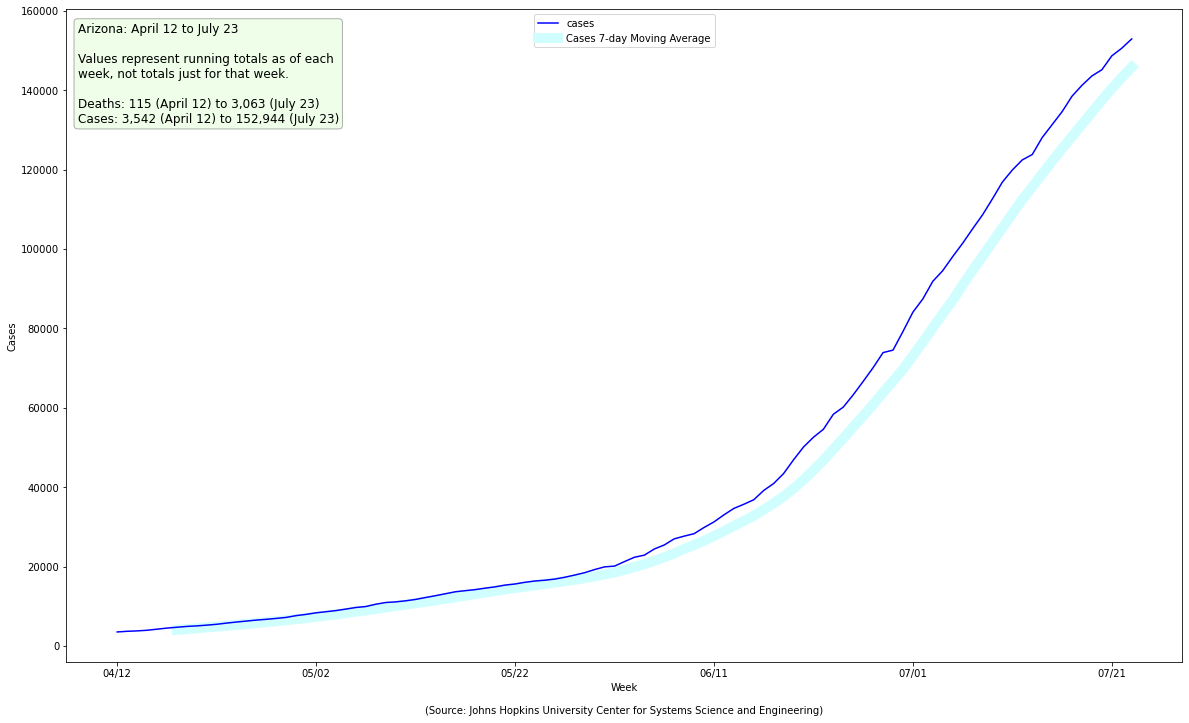

In [35]:
plot_state(df, 'Arizona', image_file='jhu-az-cases.png', metrics={MetricType.CASES}, moving_average=True)

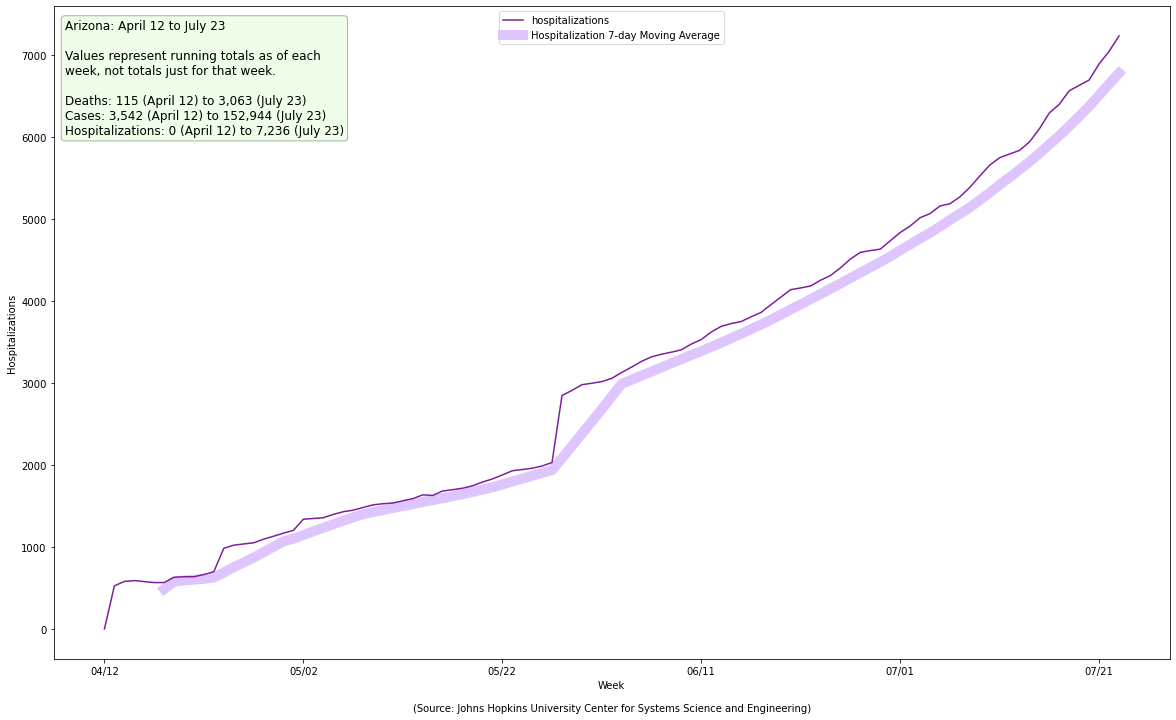

In [36]:
plot_state(df, 'Arizona', image_file='jhu-az-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Florida

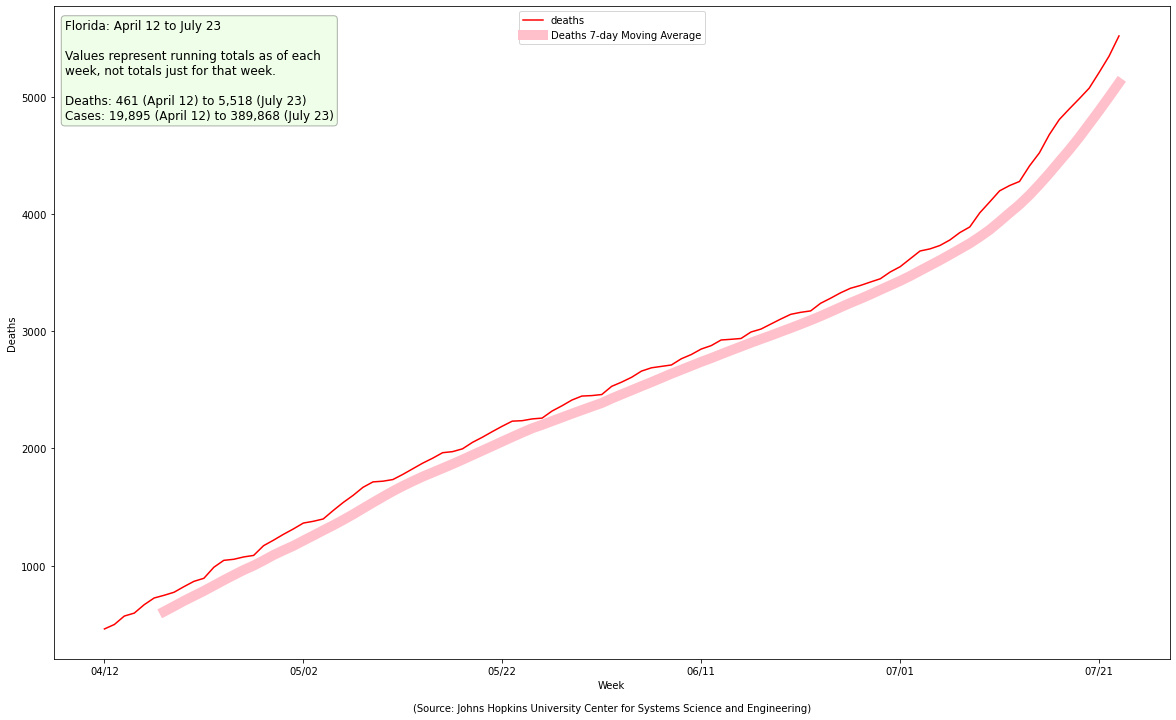

In [37]:
plot_state(df, 'Florida', image_file='jhu-fl-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

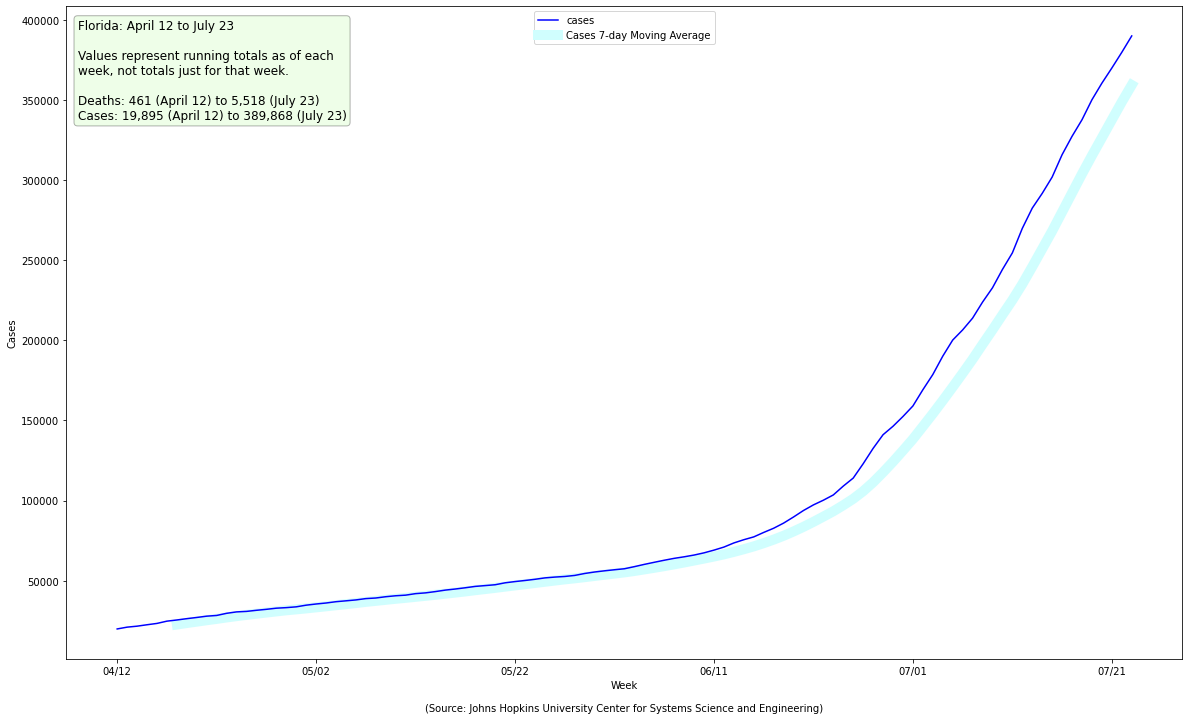

In [38]:
plot_state(df, 'Florida', image_file='jhu-fl-cases.png', metrics={MetricType.CASES}, moving_average=True)

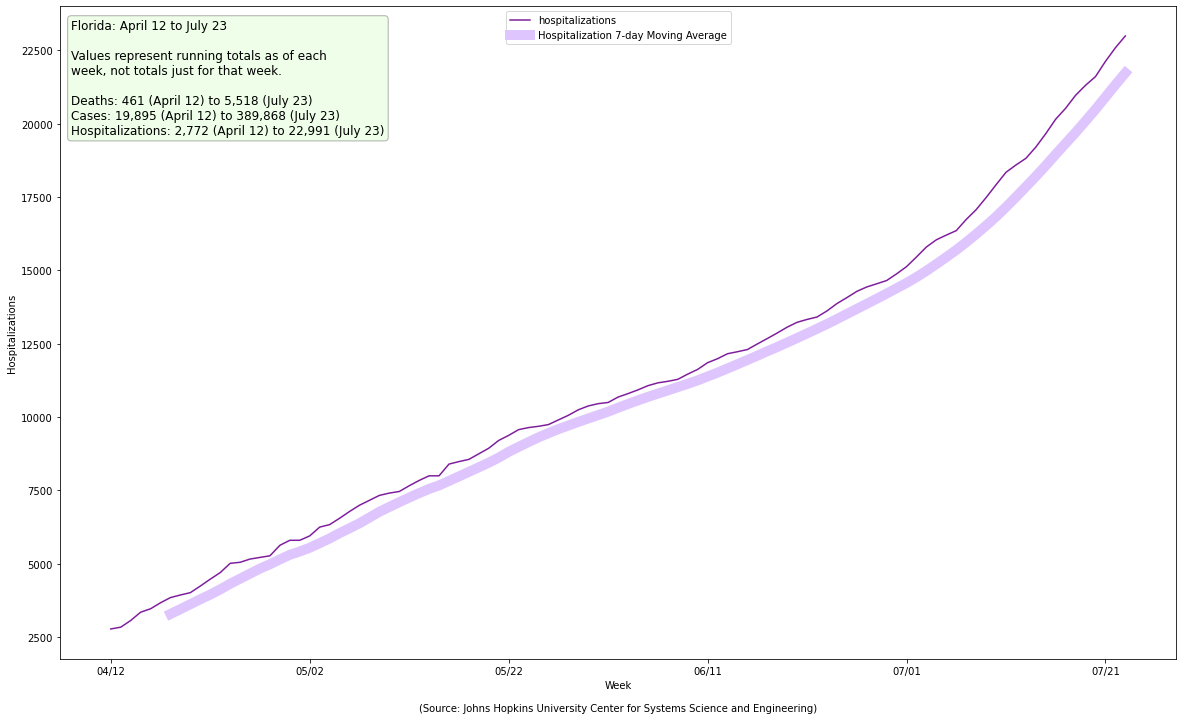

In [39]:
plot_state(df, 'Florida', image_file='jhu-fl-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

### South Carolina

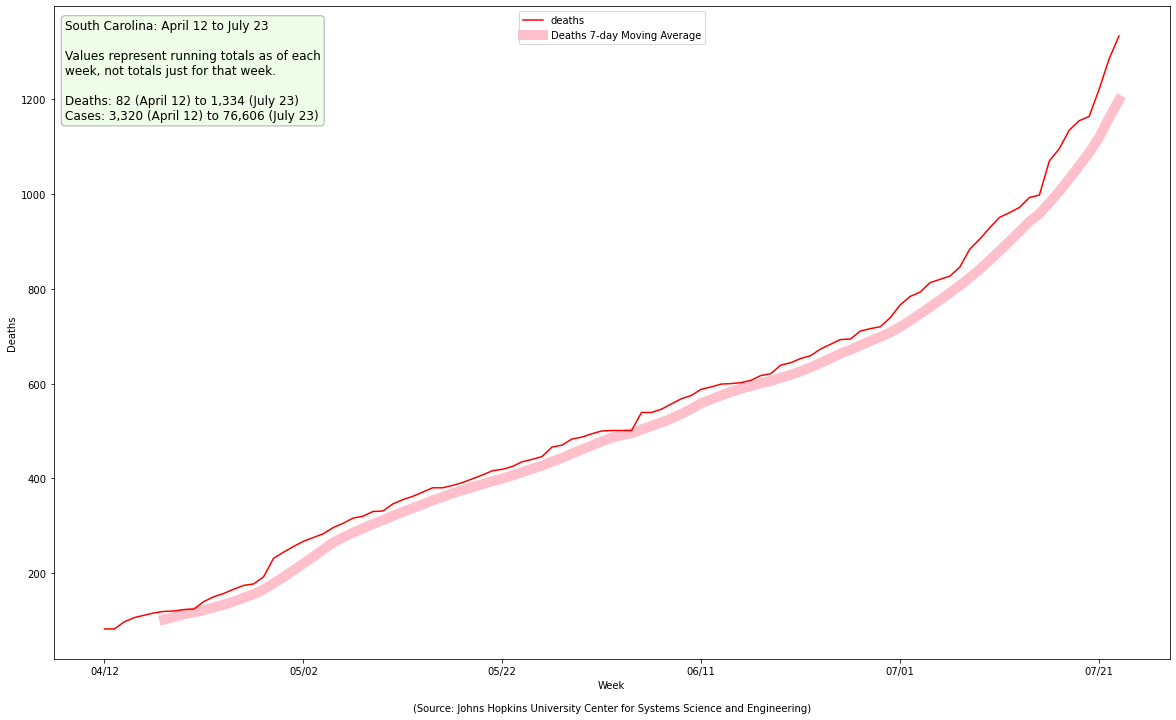

In [40]:
plot_state(df, 'South Carolina', image_file='jhu-sc-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

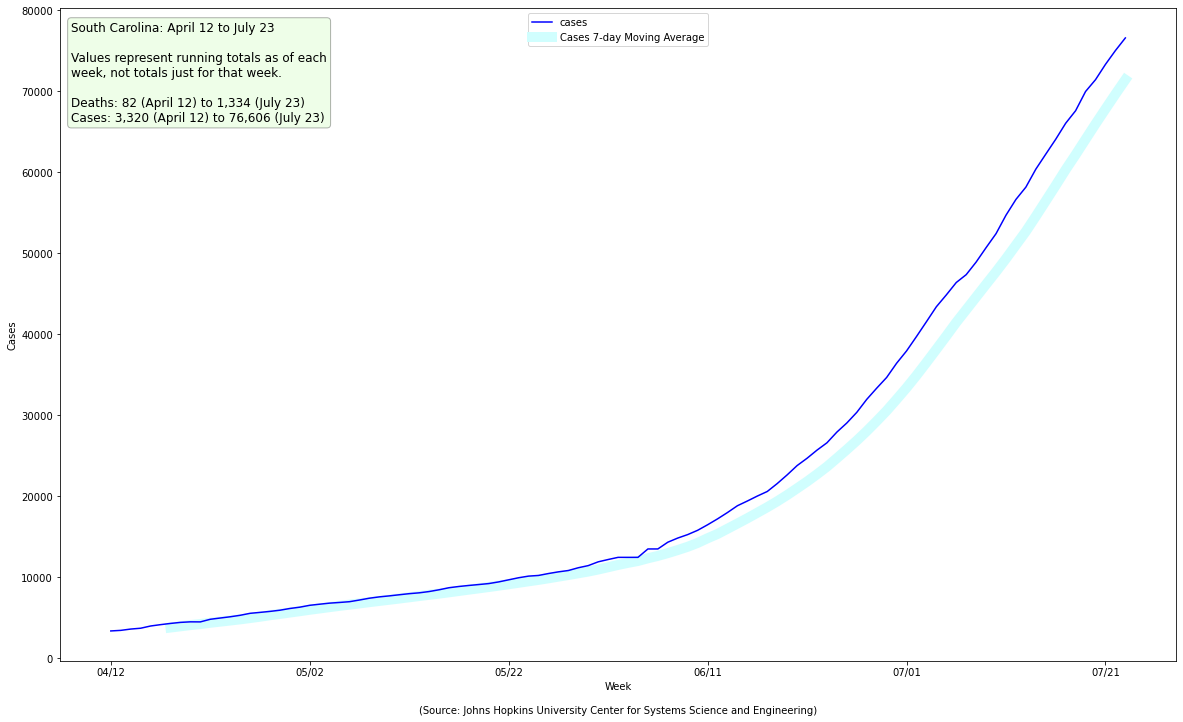

In [41]:
plot_state(df, 'South Carolina', image_file='jhu-sc-cases.png', metrics={MetricType.CASES}, moving_average=True)

#### Oklahoma

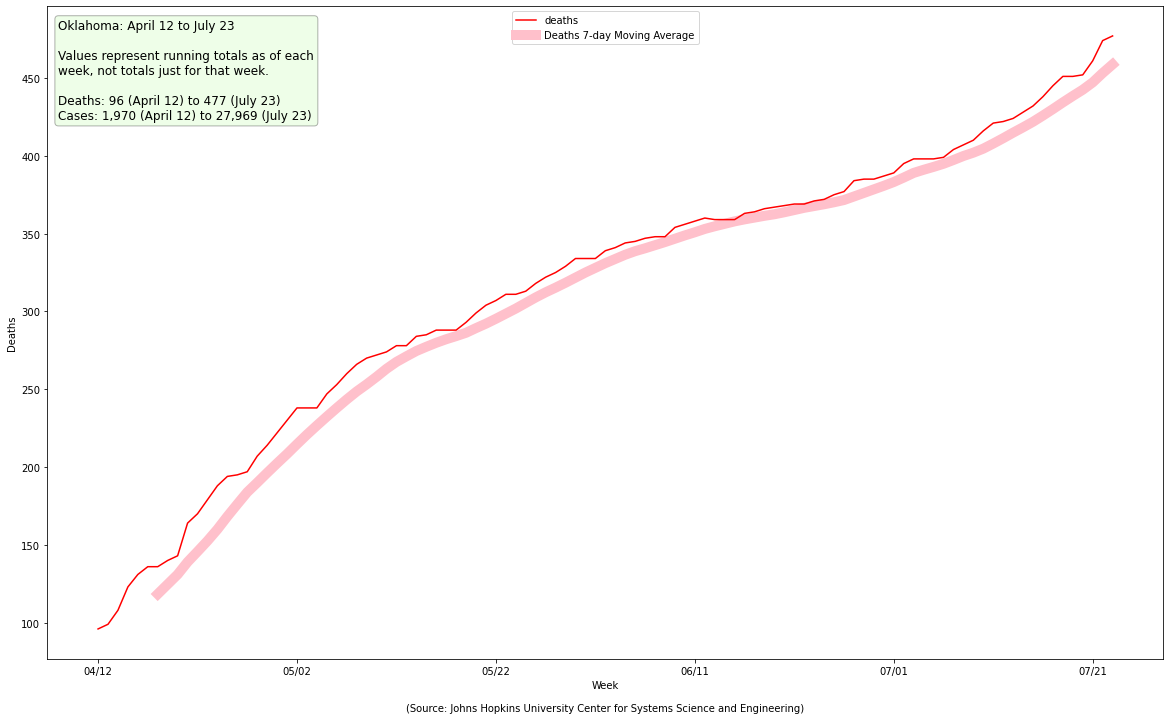

In [42]:
plot_state(df, 'Oklahoma', image_file='jhu-ok-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

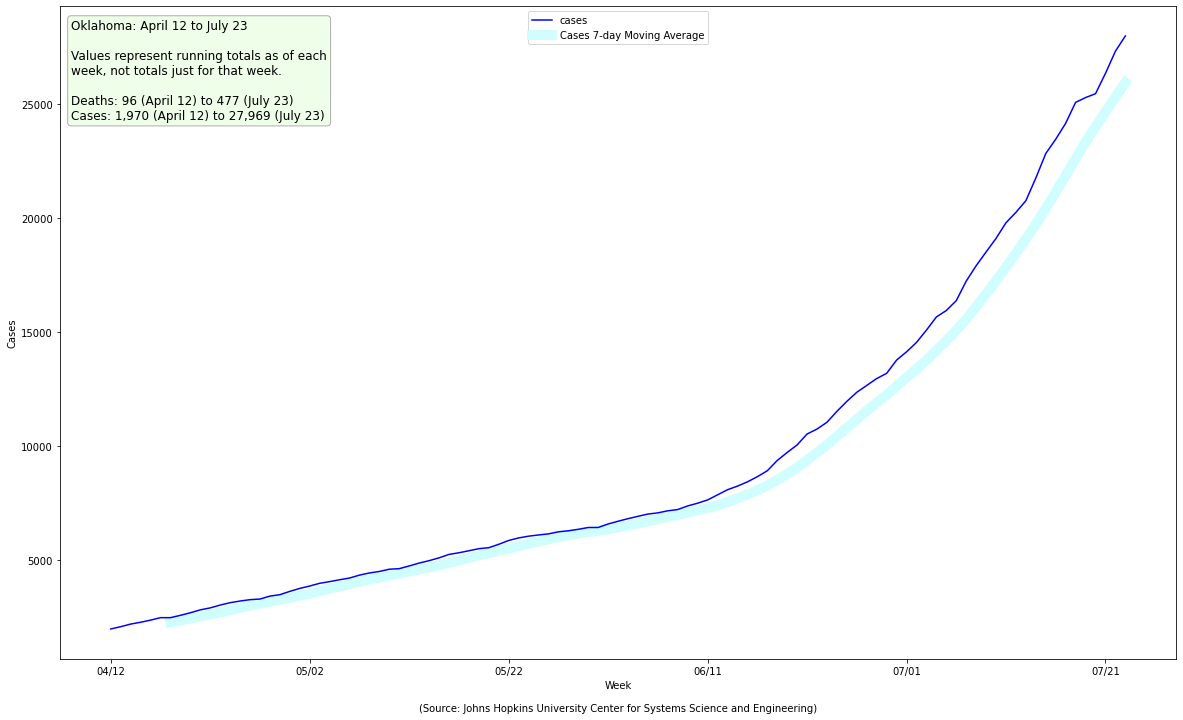

In [43]:
plot_state(df, 'Oklahoma', image_file='jhu-ok-cases.png', metrics={MetricType.CASES}, moving_average=True)

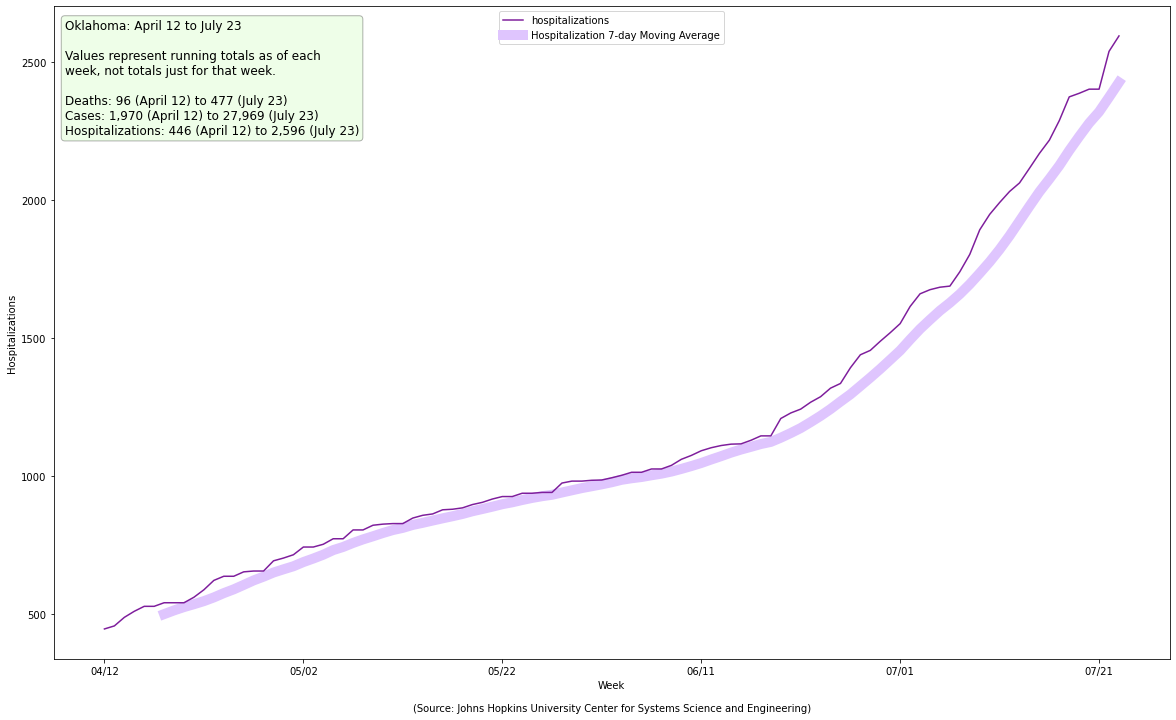

In [44]:
plot_state(df, 'Oklahoma', image_file='jhu-ok-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

## Multistate

In [45]:
def plot_states(df, states, metric=MetricType.DEATHS, per_n=1,
                populations=None, textbox_heading=None, textbox_loc=None, 
                figsize=(20, 12), legend_loc="lower right", image_file=None):
    """
    Takes a Pandas DataFrame with the Johns Hopkins data, and plots a particular
    metric once for each of a group of states, across all the dates in the
    DataFrame.
    
    Parameters:
    
    df              - The Pandas DataFrame from which to select the data.
    states          - The names of the states.
    metric          - The metric to plot. Defaults to deaths.
    per_n           - If set to 1, plot the data as is. Otherwise, do a per-capita
                      plot (i.e., number of X per n people). If per_n is not 1,
                      then population must be defined.
    populations     - The dictionary of populations per state. Only necessary
                      if per_n is greater than 1.
    figsize         - The size of the plot.
    textbox_heading - An optional heading to add to the textbox annotation
    textbox_loc     - An (x, y) tuple for the location of the text box's top
                      left corner. Defaults to the upper left.
    legend_loc      - Location of the legend, using matplotlib semantics. Defaults
                      to "lower right"
    image_file      - Name of image file in which to save plot, or None.
    """
    # Get a derived DataFrame with just the states passed in.
    # Also, we only care about the Province_State, Month_Day
    # and particular statistic column. Finally, ensure that the
    # resulting DataFrame is sorted by date, just in case the 
    # original was reordered.
    metric_col = METRIC_COLUMNS[metric]
    df2 = (df.loc[df.Region.isin(states)][['Region', 'Month_Day', metric_col]]
             .sort_values(by=['Month_Day'], inplace=False))
    if per_n > 1:
        func = lambda r: get_per_capita_float(r[metric_col], populations[r.Region])
        df2[metric_col] = df2.apply(func, axis=1)

    # GROUP BY, SUM. Hello, SQL folks...
    group = df2.groupby(['Month_Day', 'Region']).sum()
    
    # Unstack, to get each state's numbers in a separate column.
    final_df = group.unstack()

    fig, ax = p.subplots(figsize=figsize)

    # Let Pandas plot the whole thing.
    final_df.plot(ax=ax, kind='line', legend=True)
    fix_pandas_multiplot_legend(ax, legend_loc)

    # Set the X and Y axis labels. Add the credit below the X label,
    # since it's a nice place to stash it without interfering with
    # the plot.
    xlabel = ("Week\n\n"
              "(Source: Johns Hopkins University Center for Systems Science and Engineering)")
    ax.set_xlabel(xlabel)
    metric_label = METRIC_LABELS[metric]
    label = metric_label if per_n == 1 else f"{metric_label} per {per_n:,} people"
    ax.set_ylabel(label)

    # Add an explanatory text box.
    text_x, text_y = textbox_loc or (0.01, 0.987)
    heading = "" if textbox_heading is None else f"{textbox_heading}: "
    text_lines = [f"{heading}{label}\n"]
    for state in sorted(states):
        # Get the last value for the metric. It's the grand total.
        total = round(int(df2.loc[df2.Region == state][metric_col].iloc[-1]))
        text_lines.append(f"{state}: {total:,}")
    textbox(ax, text_x, text_y, '\n'.join(text_lines))
    
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))


### Northeast states

Data from some of the states that were hardest hit early on.

In [46]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

In [47]:
plot_states(df, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS,
            image_file='jhu-ne-states-deaths-per-capita.png')

AttributeError: 'DataFrame' object has no attribute 'Region'

In [ ]:
plot_states(df, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES,
            image_file='jhu-ne-states-cases-per-capita.png')

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [ ]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

In [ ]:
plot_states(df, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='jhu-s-sw-states-deaths-per-capita.png')

In [ ]:
plot_states(df, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-cases-per-capita.png')

How are some of these states doing, compared to Pennsylvania (my home state)?

In [ ]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

In [ ]:
plot_states(df, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS, 
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-deaths-per-capita.png')

In [ ]:
plot_states(df, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-cases-per-capita.png')

## Per-capita rates for all states

In [ ]:
def plot_states_per_capita(df, populations, metric=MetricType.DEATHS,
                           figsize=(25, 12), show_us_per_capita=True,
                           per_n=1_000_000, image_file=None):
    """
    Plot a per-capita bar chart comparing all states, for a particular
    metric.
    
    Parameters:
    
    df                 - The Pandas DataFrame with the data.
    populations        - The loaded dictionary of populations.
    metric             - The metric to graph. Defaults to MetricType.DEATHS
    figsize            - The graph size. Defaults to 25x12
    show_us_per_capita - If True, show a line for the overall US per
                         capita value.
    per_n              - The per-capita factor. Must be 1,000 or larger.
    image_file         - Where to save the image, or None.
    """
    fig, ax = p.subplots(figsize=figsize)
    metric_col = METRIC_COLUMNS[metric]
    color = METRIC_COLORS[metric]
    label = METRIC_LABELS[metric]

    assert per_n >= 1_000
    
    states = set(populations.keys()) - {'United States'}
    df_states = df.loc[df.Province_State.isin(states)].sort_values(by=['Date'], inplace=False)
    
    us_total = df_states[['Province_State', metric_col]].groupby(['Province_State']).max().sum()
    us_per_capita = get_per_capita_int(us_total, populations['United States'], per_n=per_n)

    df_states['Per_Capita'] = df_states.apply(
        lambda r: get_per_capita_float(r[metric_col], populations[r.Province_State], per_n=per_n),
        axis=1
    )

    df_grouped = df_states[['Province_State', 'Per_Capita']].groupby(['Province_State']).max()

    # We're using zorder here to ensure that the horizontal line showing the
    # US per capita value shows up behind the bars.
    df_grouped.plot.bar(ax=ax, color=color, zorder=2, legend=False)
    if show_us_per_capita:
        ax.axhline(us_per_capita, color="lightgray", zorder=1)
        ax.set_yticks(ax.get_yticks() + [us_per_capita])

    # Set the X and Y axis labels. Add the credit below the X label,
    # since it's a nice place to stash it without interfering with
    # the plot.
    xlabel = ("State\n\n"
              "(Source: Johns Hopkins University Center for Systems Science and Engineering)")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(f"{label} for {per_n:,} people")

    # See https://stackoverflow.com/a/25449186
    # (specifically, the first comment.)
    for patch in ax.patches:
        val = f"{round(int(patch.get_height())):,}"
        x = patch.get_x() + (patch.get_width() / 2)
        y = patch.get_height()
        ax.annotate(val, (x, y), ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', zorder=2)

    if show_us_per_capita:
        text = f"U.S. {label} per {per_n:,} people: {us_per_capita:,}"
        textbox(ax, 0.01, 0.98, text)

    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))

    return (fig, ax)


In [ ]:
plot_states_per_capita(df, populations, image_file='jhu-state-deaths-per-capita.png');

In [ ]:
plot_states_per_capita(df, populations, metric=MetricType.CASES, image_file='jhu-state-cases-per-capita.png');